This cell generates data. 

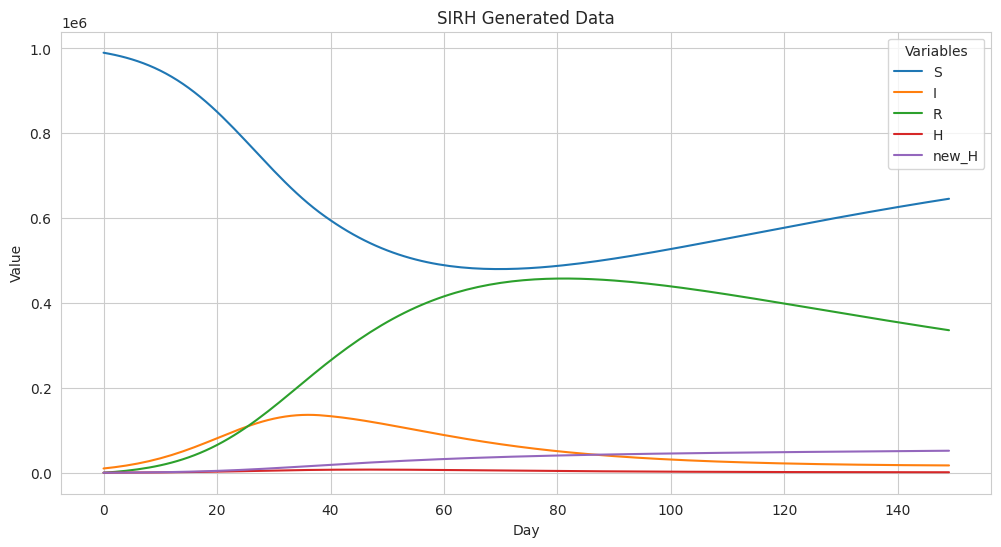

In [1]:
from src.particle_filter.parameters import ModelParameters
from src.particle_filter.transition import (
    Transition,
    OUModel,
)
from jax.random import PRNGKey
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

days = 150
step_beta_switch = 40

initial_beta = 0.25
final_beta = 0.15

# Create a linear decline from initial_beta to final_beta
linear_decline = np.linspace(initial_beta, final_beta, step_beta_switch)

# Combine the declining part with the final constant value
step_beta = np.concatenate([linear_decline, [final_beta] * (days - step_beta_switch)])

pop = 1000000
infected = 0.01 * pop
susceptible = pop - infected
initial_state = jnp.array([susceptible, infected, 0, 0, 0, 0.3])
key = PRNGKey(0)

import paths
import os

config_path = os.path.join(paths.PF_DIR, "config.toml")

ou_model = OUModel(config_path)

det_output = [initial_state.copy()]
case_reports = [0]


def det_update(state, time_step):
    state = state.at[5].set(step_beta[time_step])
    update = ou_model.det_component(state, time_step)
    case_reports.append(update[4].item())
    state += update
    return state


for t in range(1, days):
    det_output.append(det_update(det_output[-1], t))


def plot_output(output):
    data = np.array(output)
    labels = ["S", "I", "R", "H", "new_H"]
    # Create a plot for each variable
    plt.figure(figsize=(12, 6))

    # for each day
    for i in range(data.shape[1] - 1):
        # plot each compartment
        plt.plot(range(data.shape[0]), data[:, i], label=labels[i])

    plt.title("SIRH Generated Data")
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.legend(title="Variables")
    plt.show()


plot_output(det_output)

## Running the Particle Filter

In [2]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)

In [3]:
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

Running Particle Filter: 100%|██████████| 150/150 [03:10<00:00,  1.27s/it]


In [2]:
import matplotlib.pyplot as plt


def prepare_real_data(generated_data, true_beta):
    """Prepares the true data array."""
    real_data = np.array(generated_data).T
    real_data[5, :] = true_beta
    return real_data


def compute_quantiles(data, quantiles):
    """Computes the specified quantiles for the given data."""
    return np.percentile(data, [q * 100 for q in quantiles], axis=0)


def plot_hosp_estimates_vs_true(T, quantile_hosp_estimates, case_reports):
    """Plots the hospital estimates against the true case reports."""
    plt.figure(figsize=(10, 6))
    plt.title("Case Reports: Particle Estimates vs. True")
    plt.fill_between(
        np.arange(T),
        quantile_hosp_estimates[0],
        quantile_hosp_estimates[-1],
        color="blue",
        alpha=0.1,
    )
    plt.fill_between(
        np.arange(T),
        quantile_hosp_estimates[1],
        quantile_hosp_estimates[-2],
        color="blue",
        alpha=0.3,
    )
    plt.plot(np.arange(T), quantile_hosp_estimates[2], color="red")  # Median
    plt.plot(np.arange(T), case_reports, color="black", linestyle="--")  # True data
    plt.xlabel("Time Step")
    plt.ylabel("Hospital Estimates")
    plt.show()


def plot_state_variables(states, true_data, quantiles, state_labels):
    """Plots each state variable separately with quantiles."""
    N, S, T = states.shape

    for i in range(S):
        if i == 4:  # Ignore new_H compartment
            continue

        variable_data = states[:, i, :]  # Shape (N, T)
        quantile_values = compute_quantiles(variable_data, quantiles)

        plt.figure(figsize=(10, 6))
        plt.fill_between(
            np.arange(T),
            quantile_values[0],
            quantile_values[-1],
            color="blue",
            alpha=0.1,
        )
        plt.fill_between(
            np.arange(T),
            quantile_values[1],
            quantile_values[-2],
            color="blue",
            alpha=0.3,
        )
        plt.plot(np.arange(T), quantile_values[2], color="red")  # Median
        plt.plot(
            np.arange(T), true_data[i, :], color="black", linestyle="--"
        )  # True data

        plt.title(state_labels[i])
        plt.xlabel("Time Step")
        plt.ylabel(state_labels[i])
        plt.tight_layout()
        plt.show()
        plt.close()


def generate_plots(
    generated_data, true_beta, particle_estimates, reported_hosp, pf_states
) -> None:
    """Main function to orchestrate the data preparation and plotting."""
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    state_labels = ["S", "I", "R", "H", "new_H", "beta"]

    true_data = prepare_real_data(generated_data, true_beta)
    quantile_hosp_estimates = compute_quantiles(particle_estimates, quantiles)

    # Plot hospital estimates vs. true case reports
    plot_hosp_estimates_vs_true(
        pf_states.shape[2], quantile_hosp_estimates, reported_hosp
    )

    # Plot state variables
    plot_state_variables(pf_states, true_data, quantiles, state_labels)

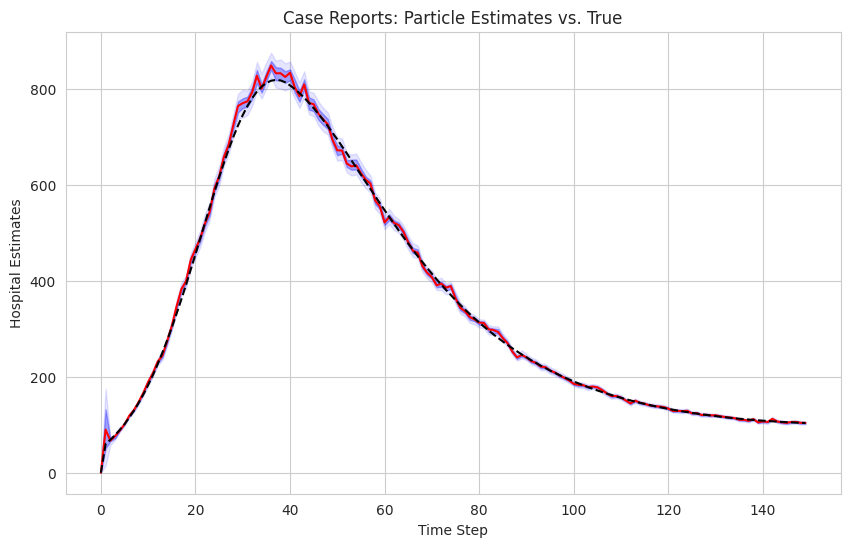

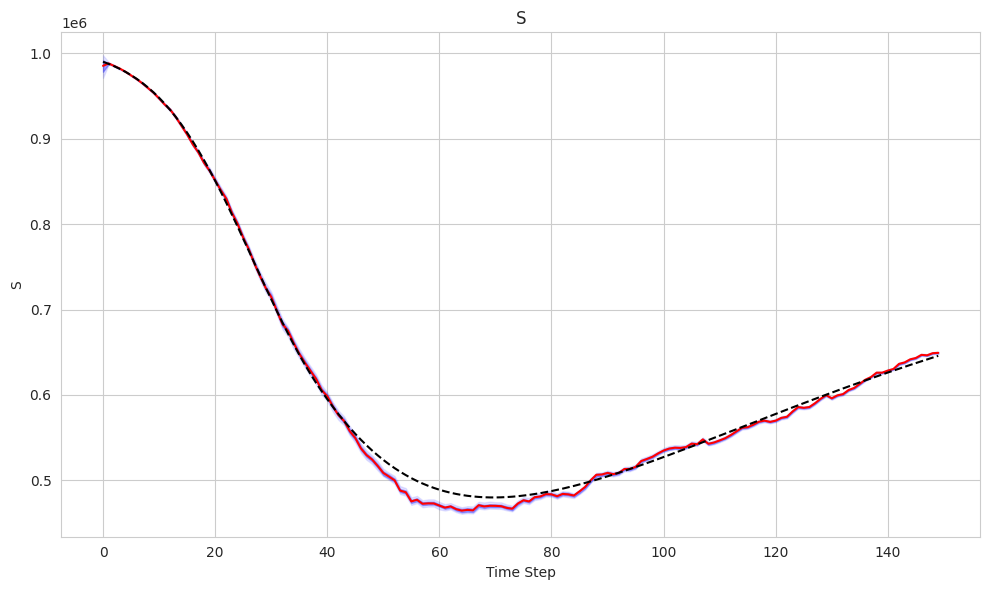

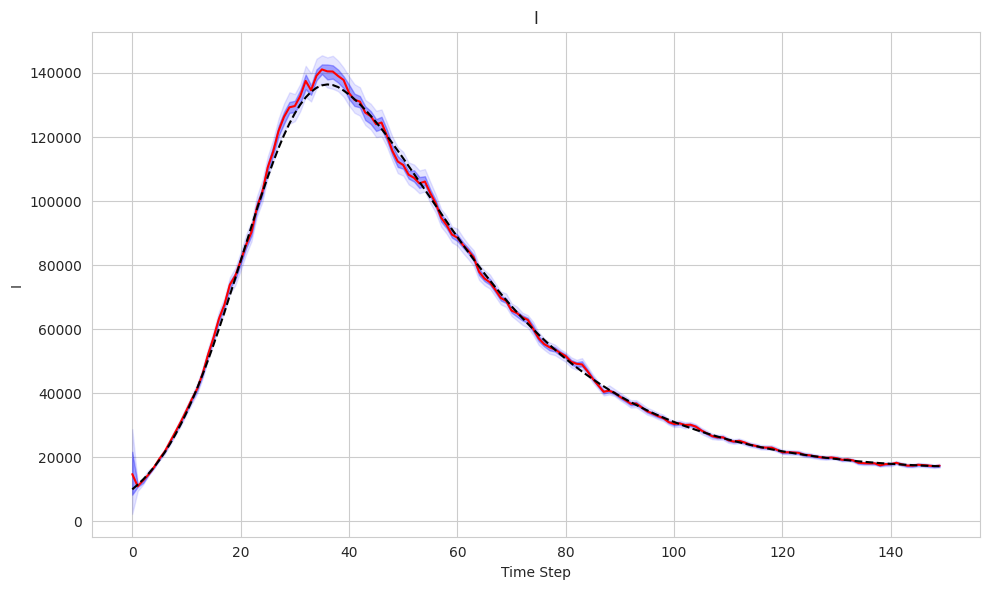

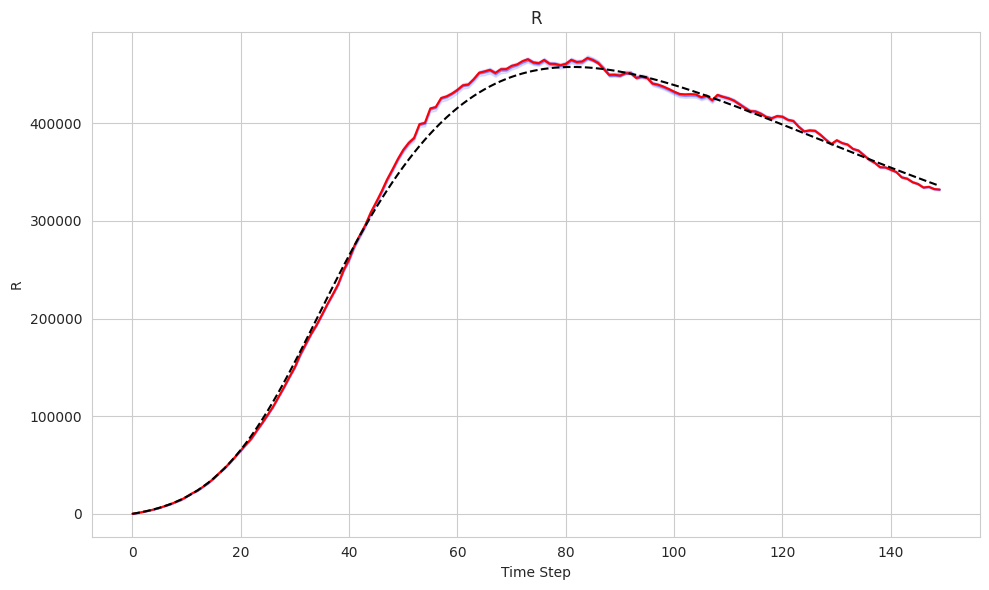

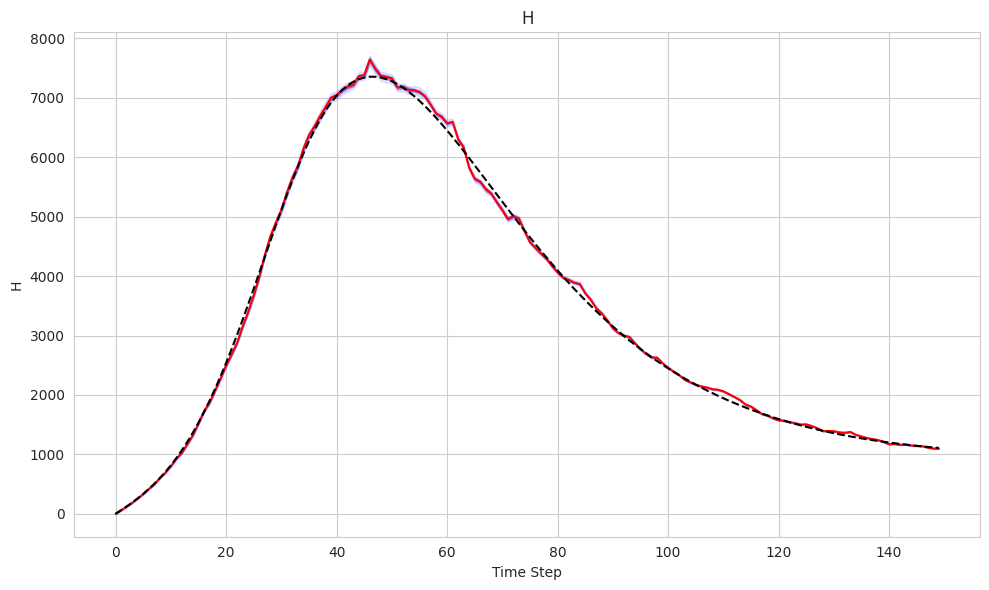

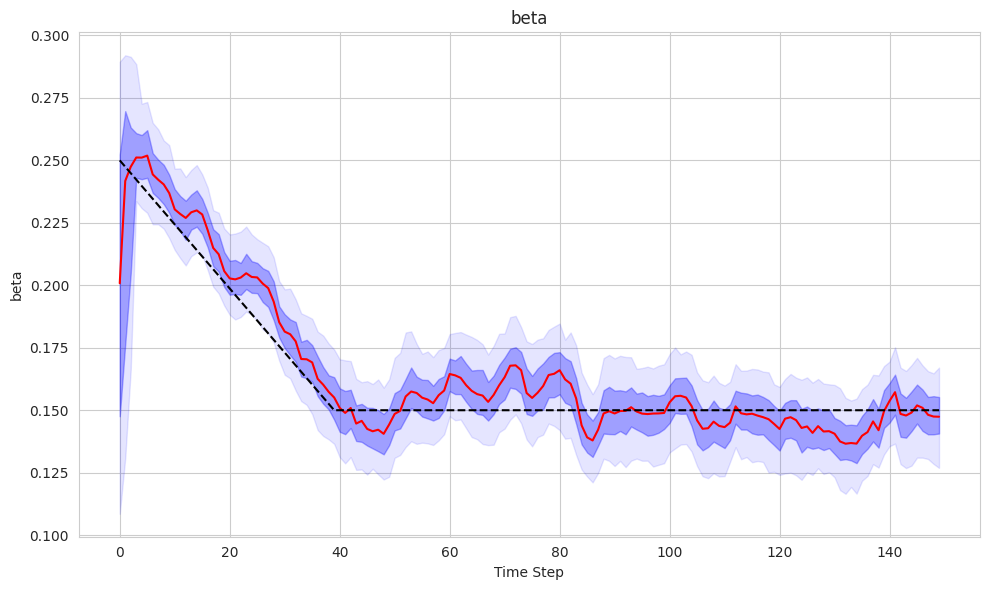

In [4]:
generate_plots(det_output, step_beta, hosp_estimates, case_reports, states)

## Increase stochastic variance

Changed dW variance from 0.1 to 0.2. 

In [5]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

Running Particle Filter: 100%|██████████| 150/150 [03:31<00:00,  1.41s/it]


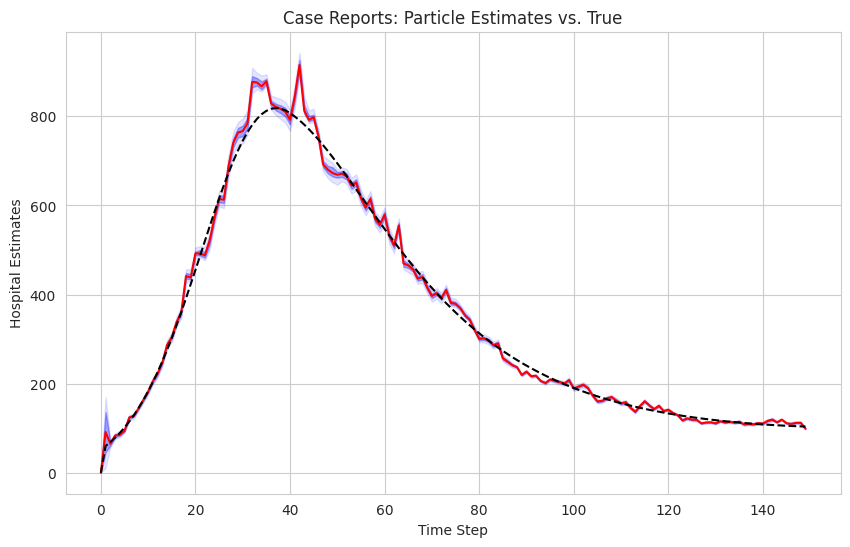

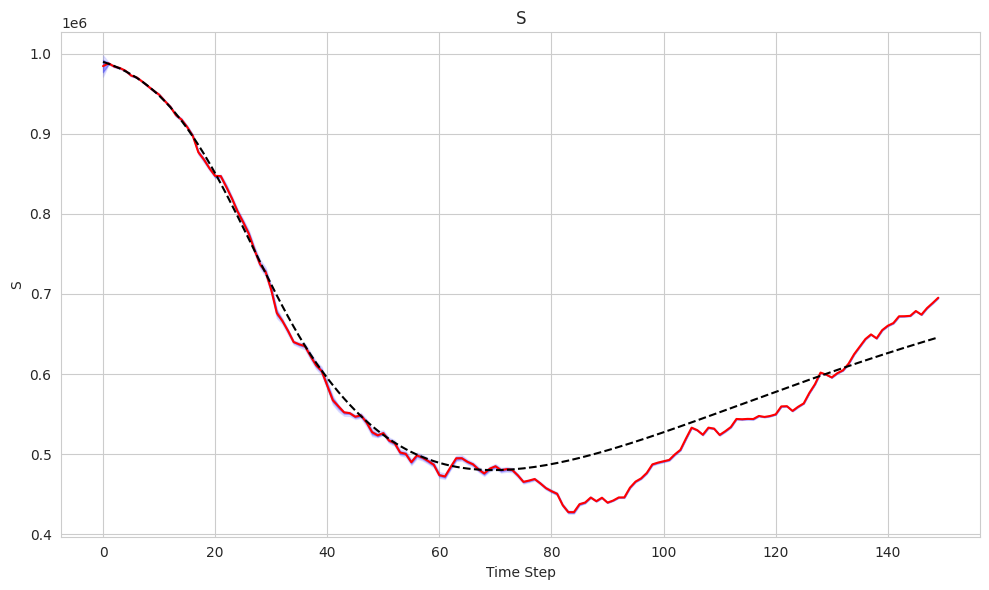

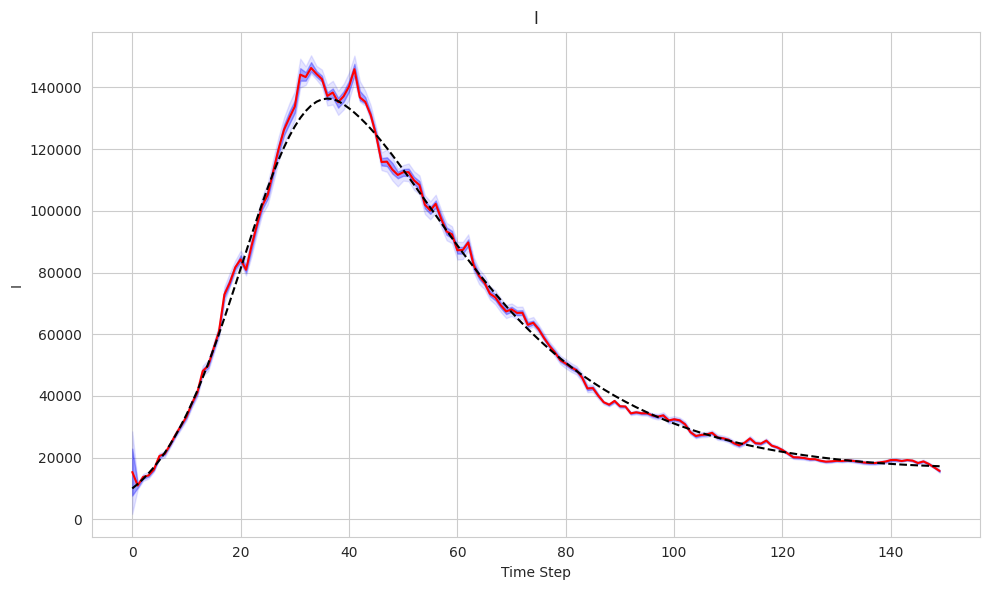

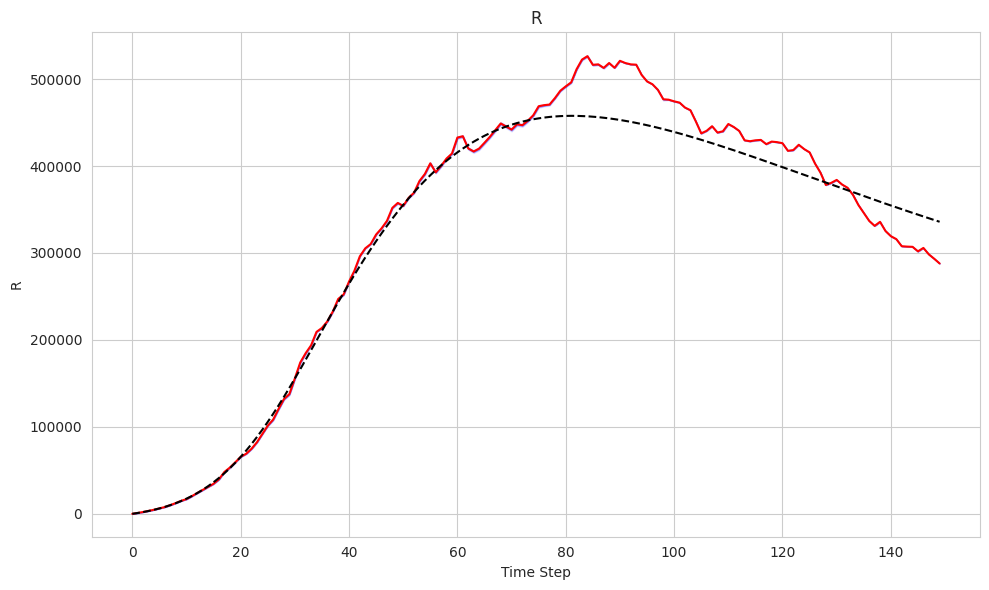

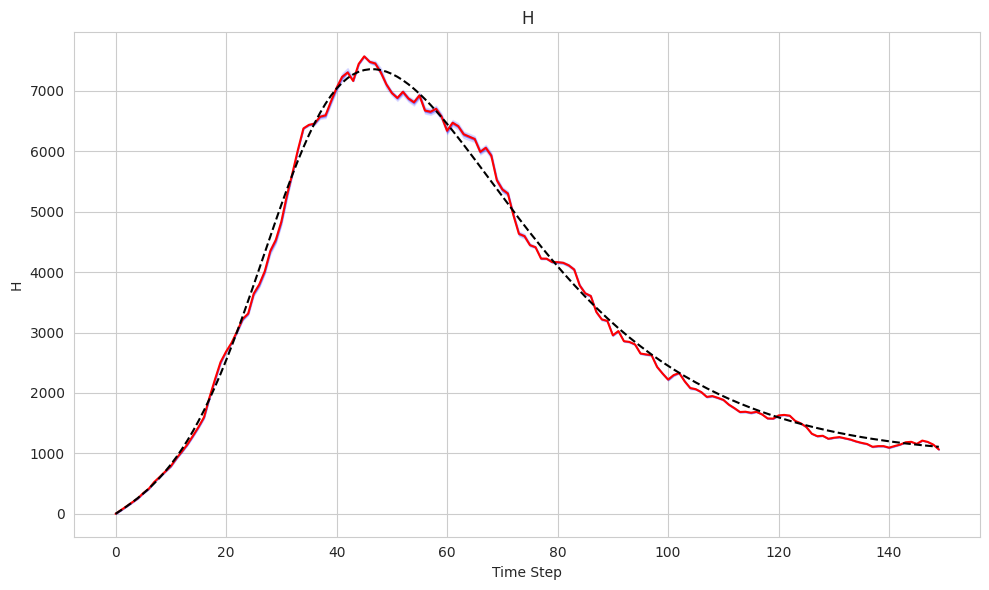

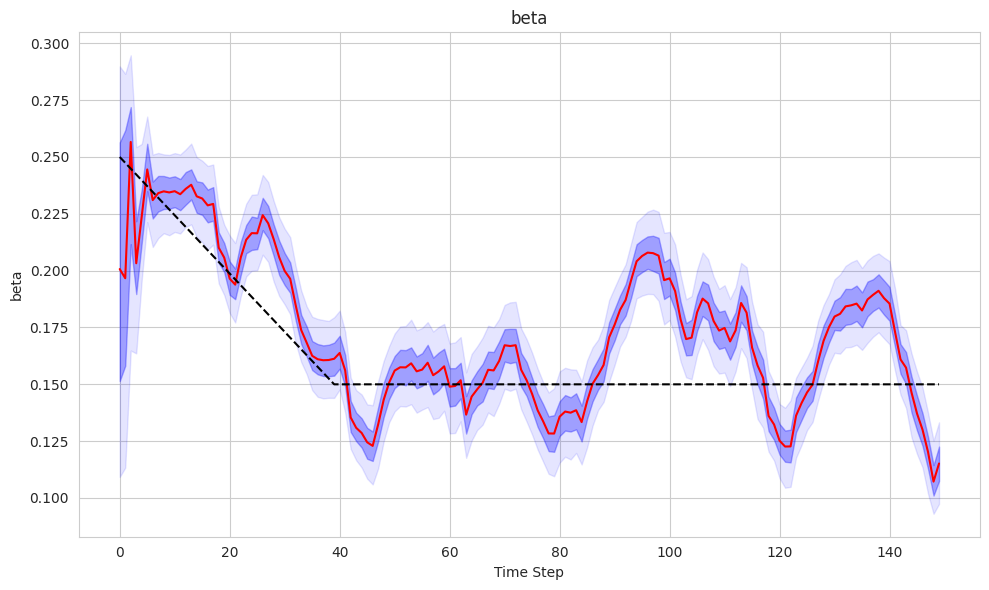

In [5]:
generate_plots(det_output, step_beta, hosp_estimates, case_reports, states)

## Increase Particle Count
From 300 to 1000

In [ ]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

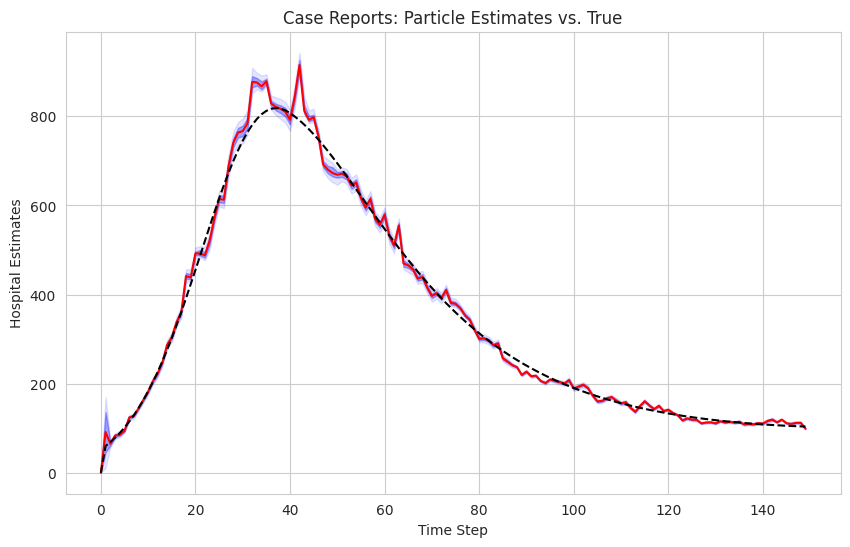

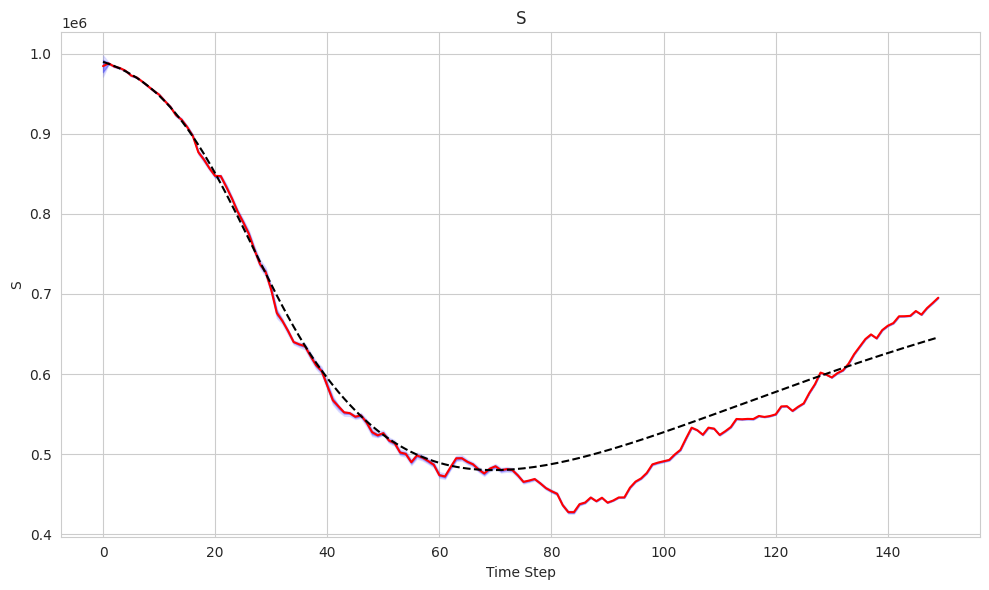

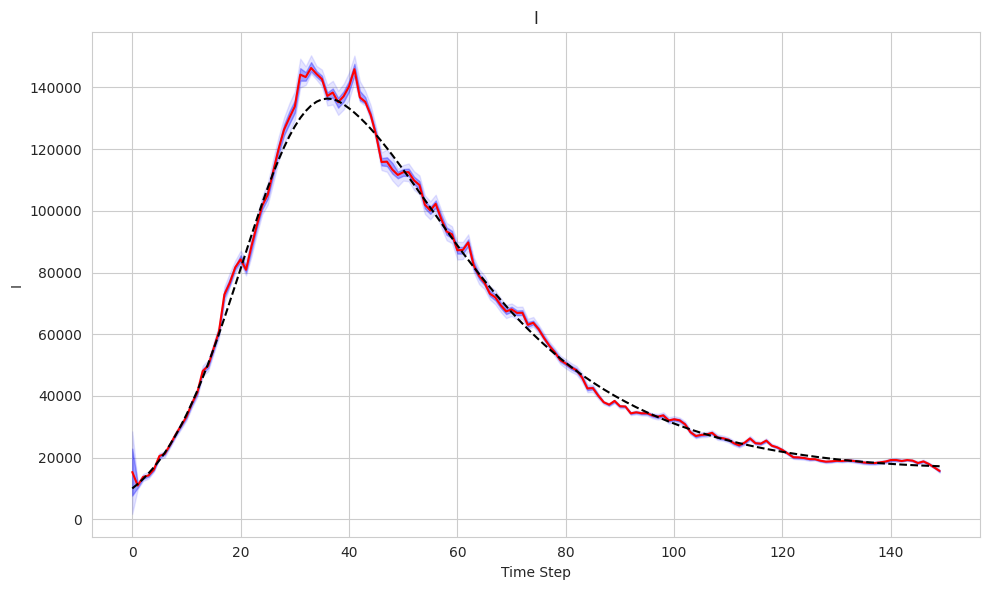

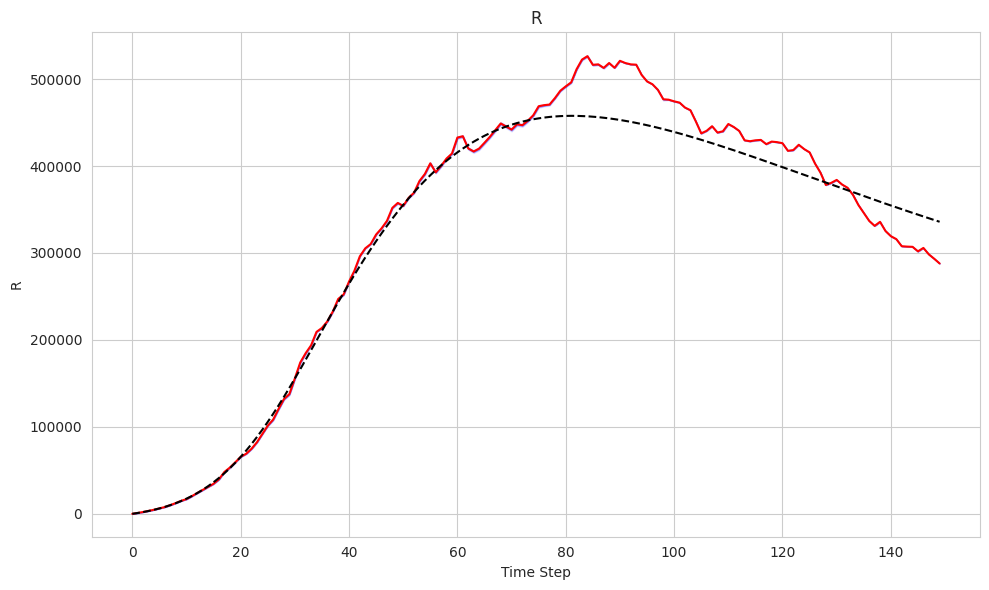

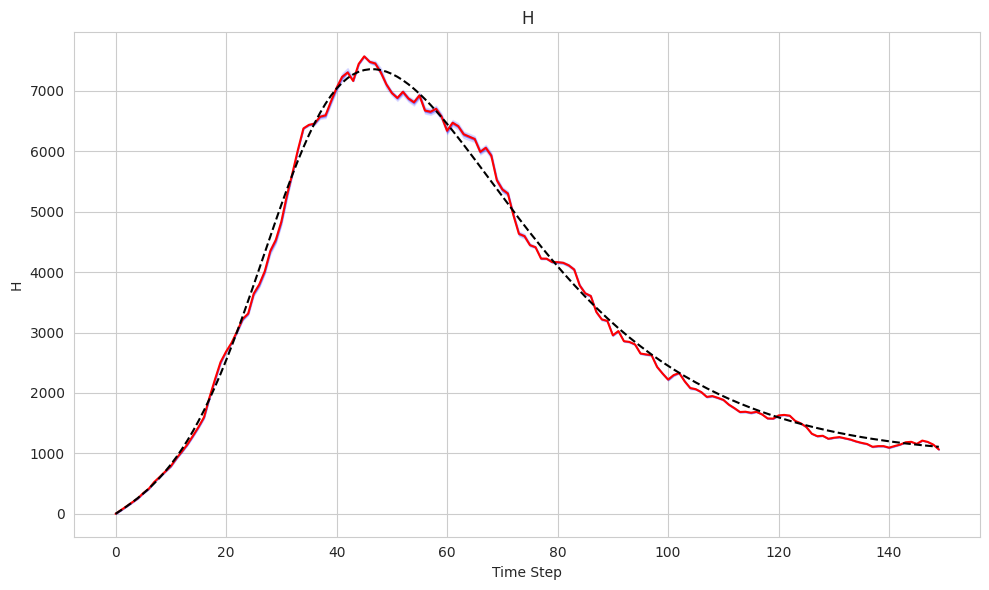

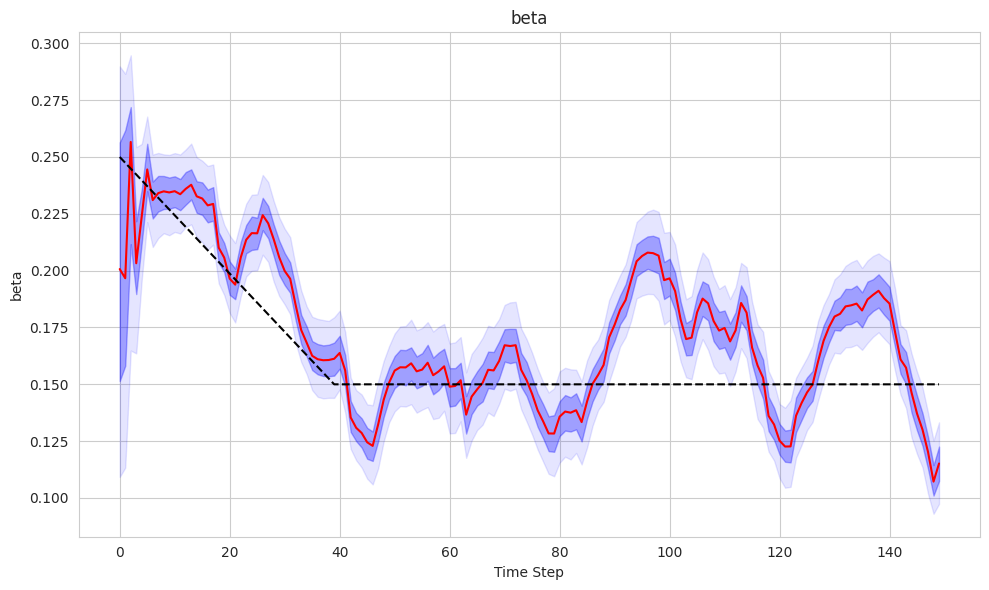

In [6]:
generate_plots(det_output, step_beta, hosp_estimates, case_reports, states)

## 500 Particles, dW Volatility = 0.1

In [7]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

Running Particle Filter: 100%|██████████| 150/150 [05:25<00:00,  2.17s/it]


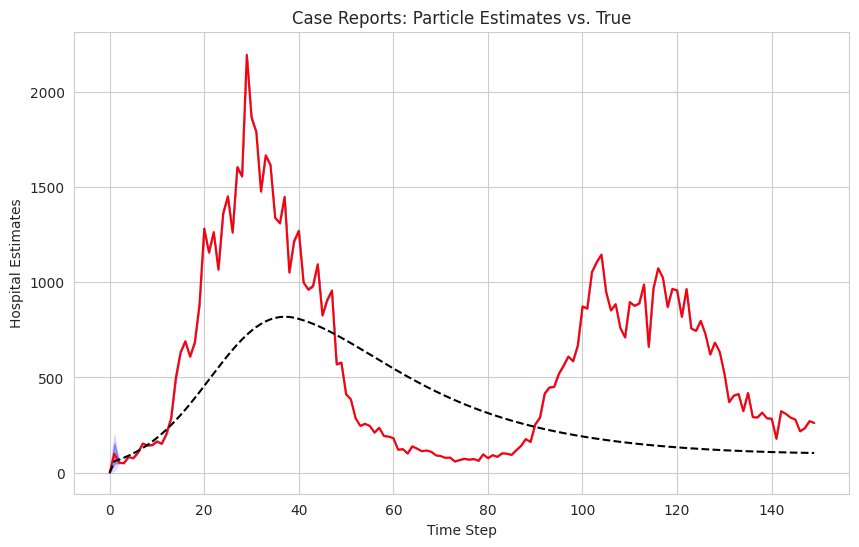

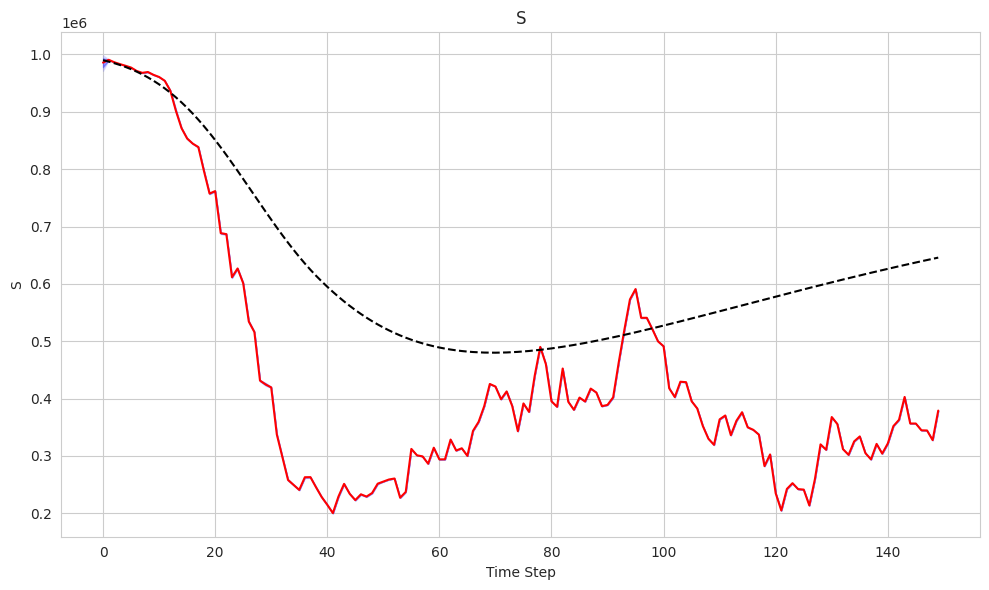

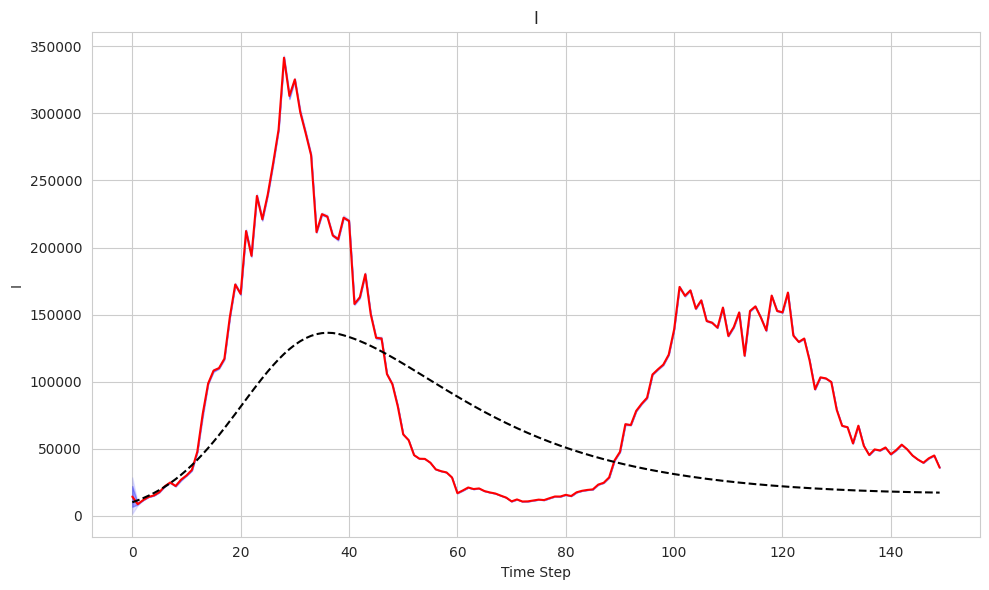

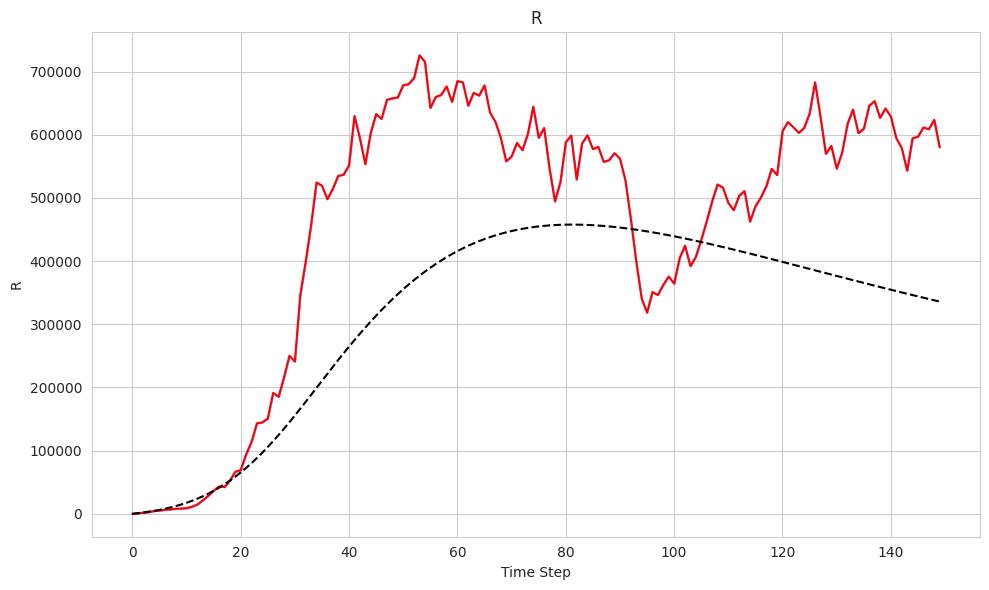

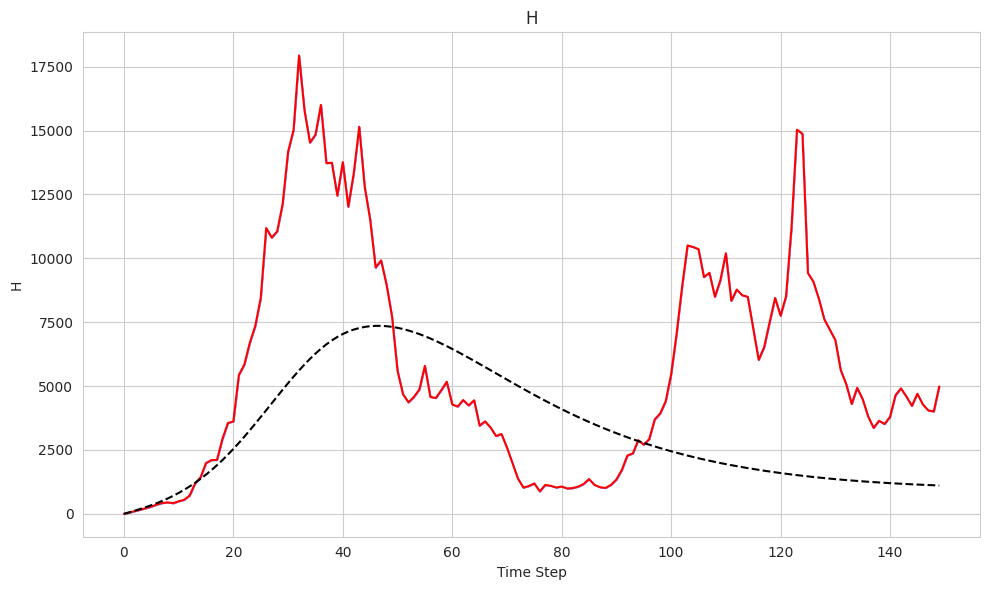

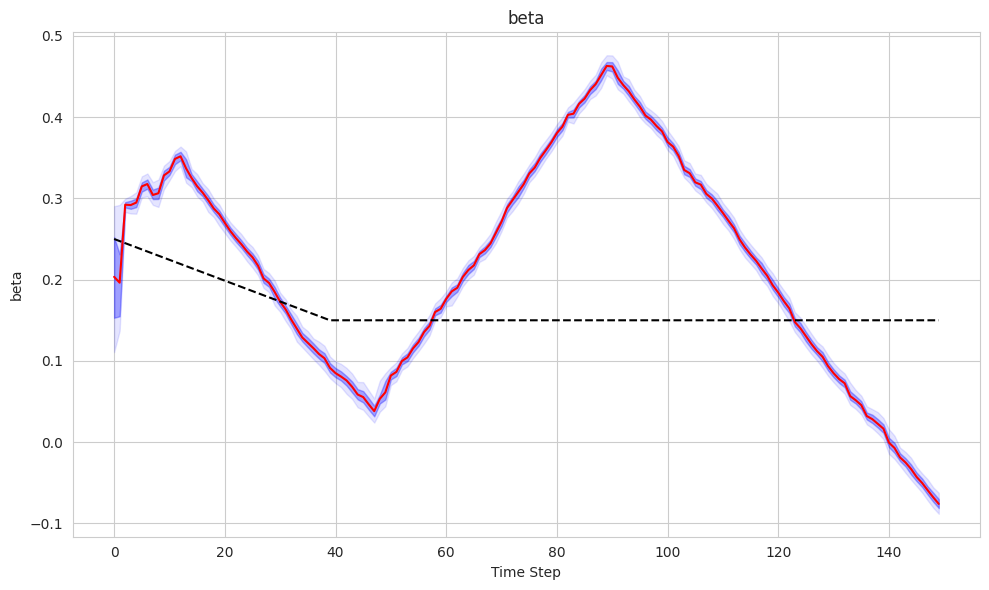

In [8]:
generate_plots(det_output, step_beta, hosp_estimates, case_reports, states)

# 500 Particles, dW volatitility = 0.01

In [9]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

Running Particle Filter: 100%|██████████| 150/150 [05:10<00:00,  2.07s/it]


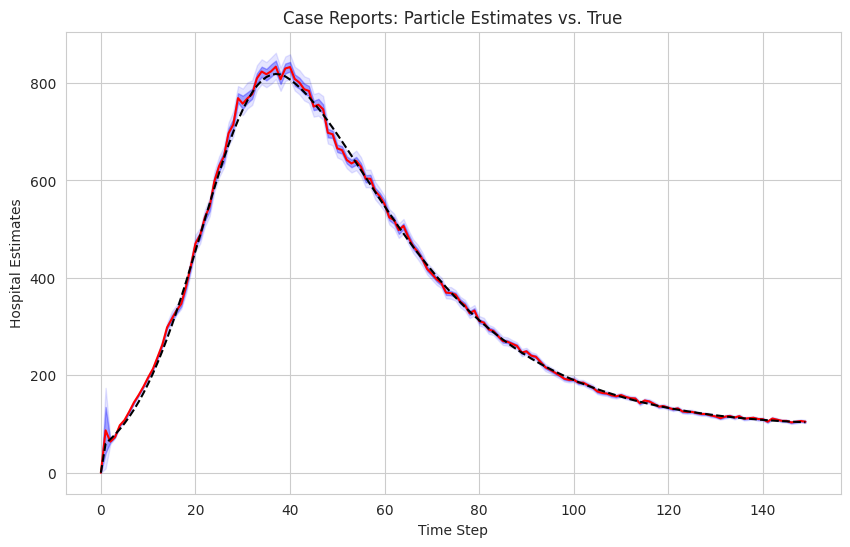

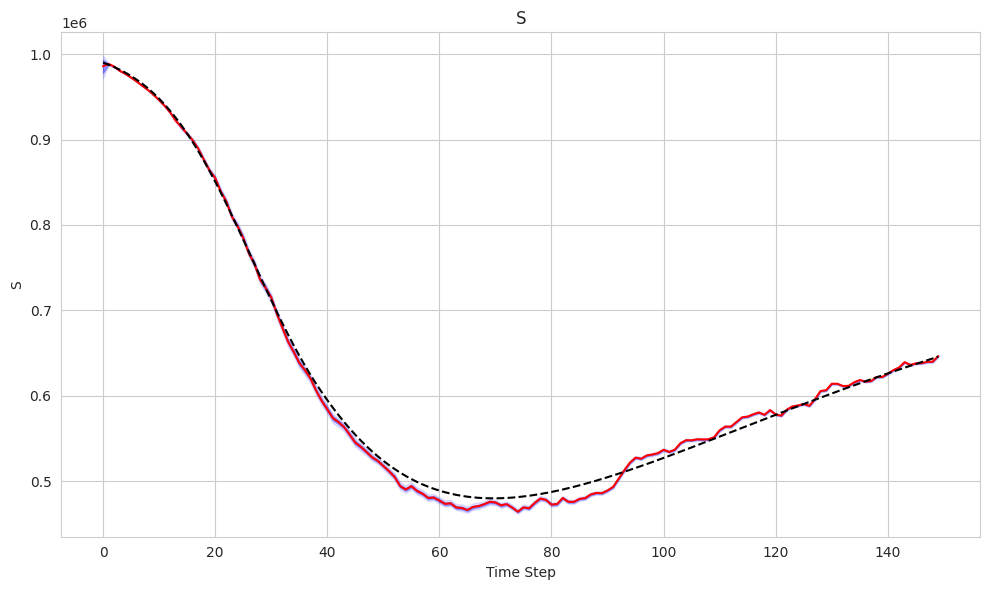

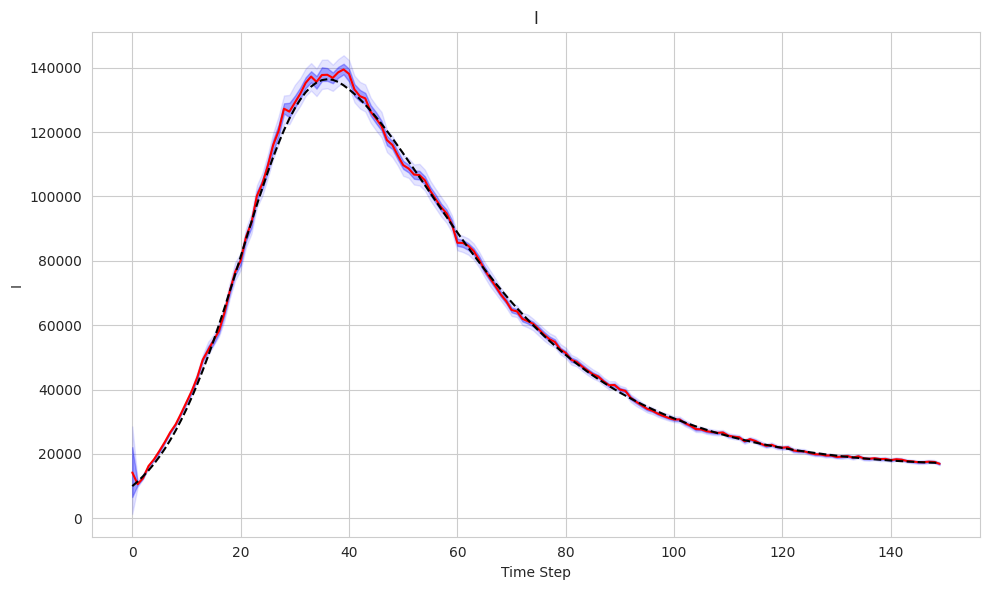

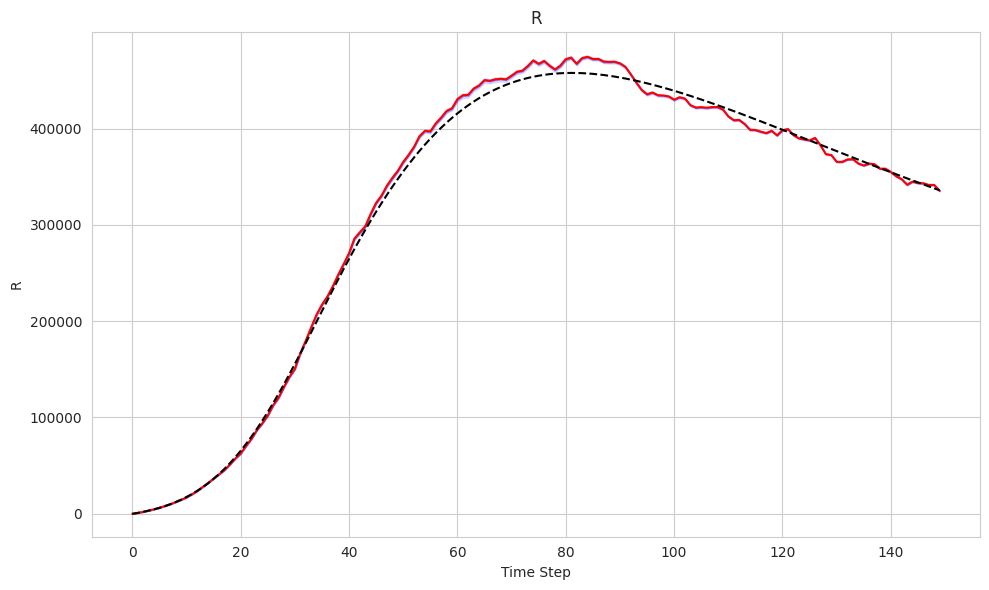

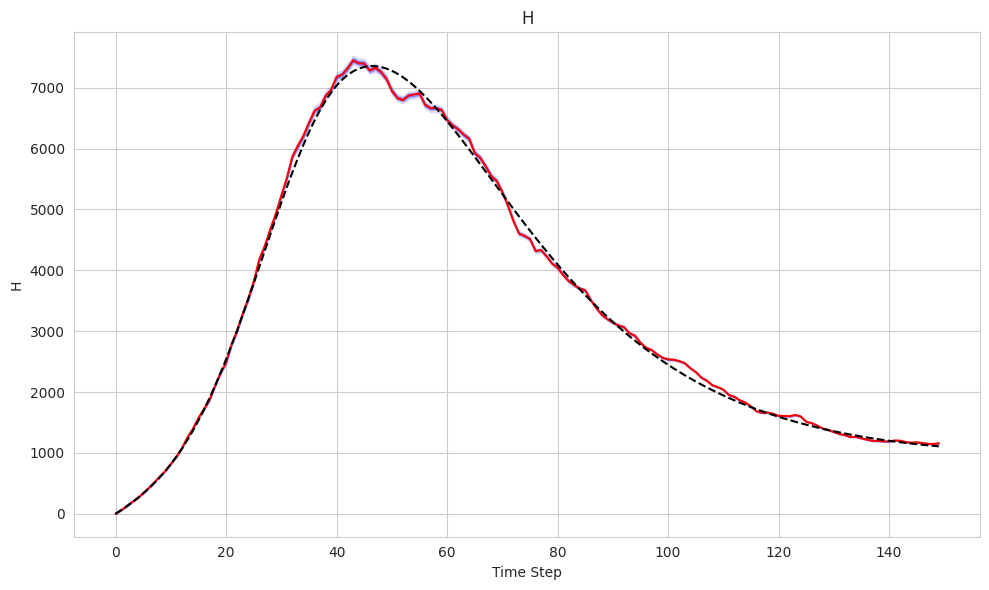

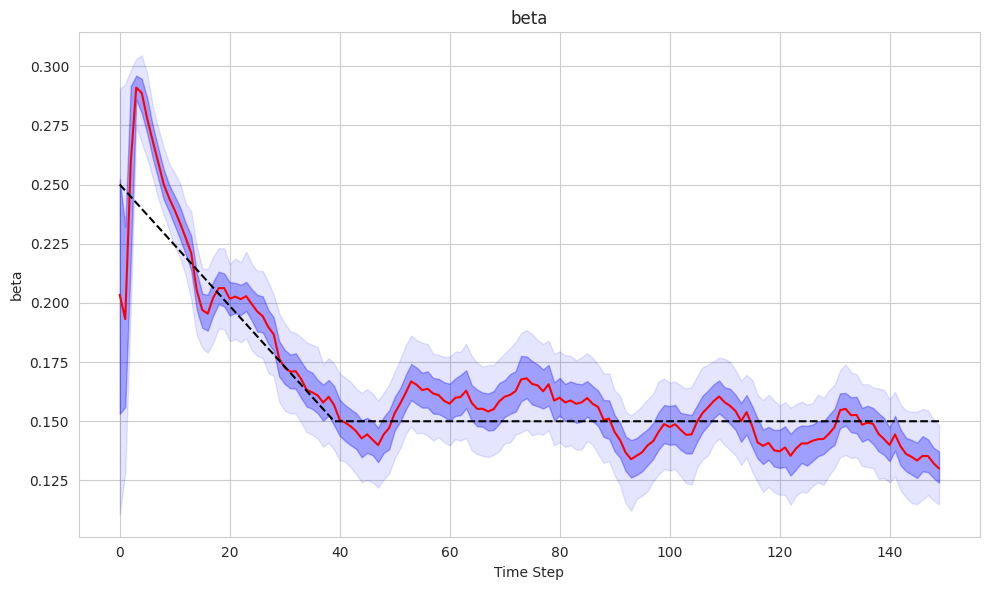

In [10]:
generate_plots(det_output, step_beta, hosp_estimates, case_reports, states)

## Change Beta mu = 0.2

In [11]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

Running Particle Filter: 100%|██████████| 150/150 [05:37<00:00,  2.25s/it]


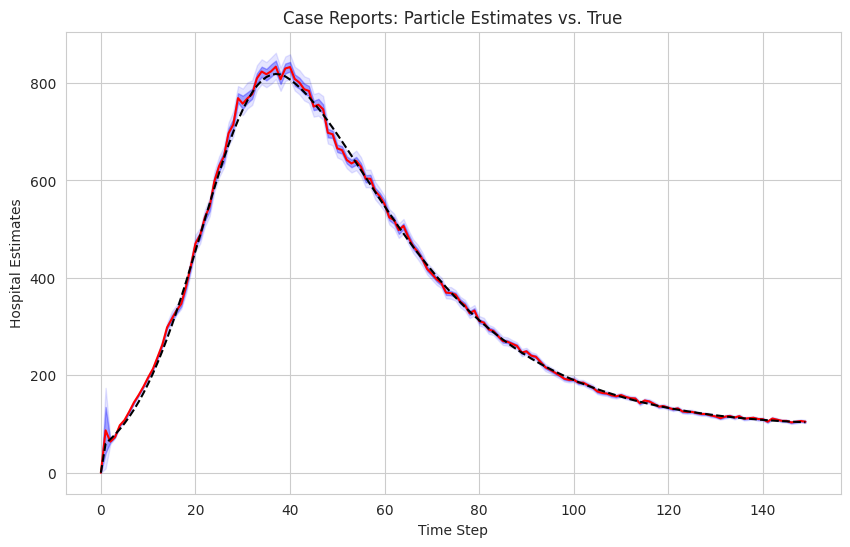

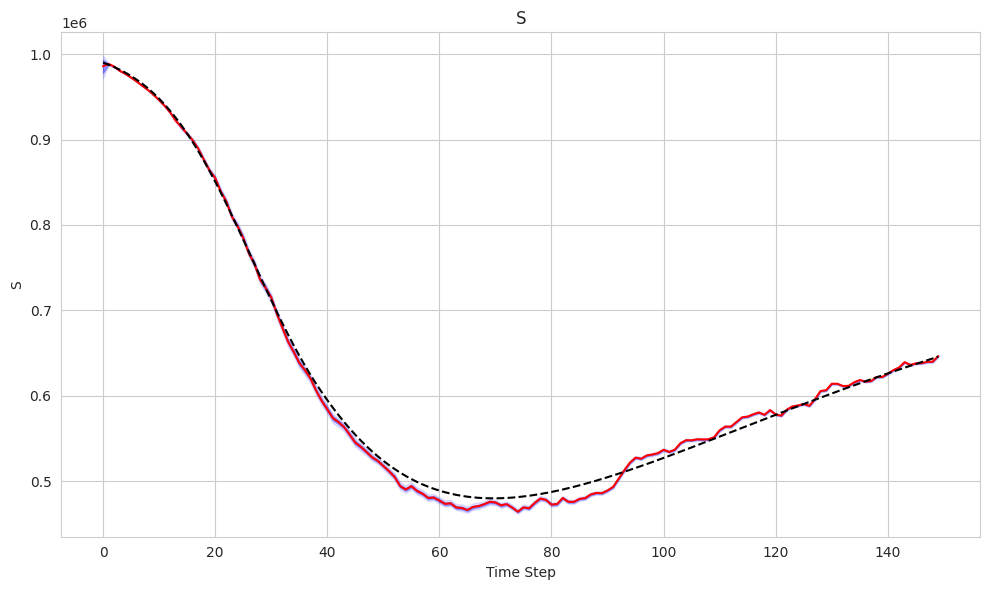

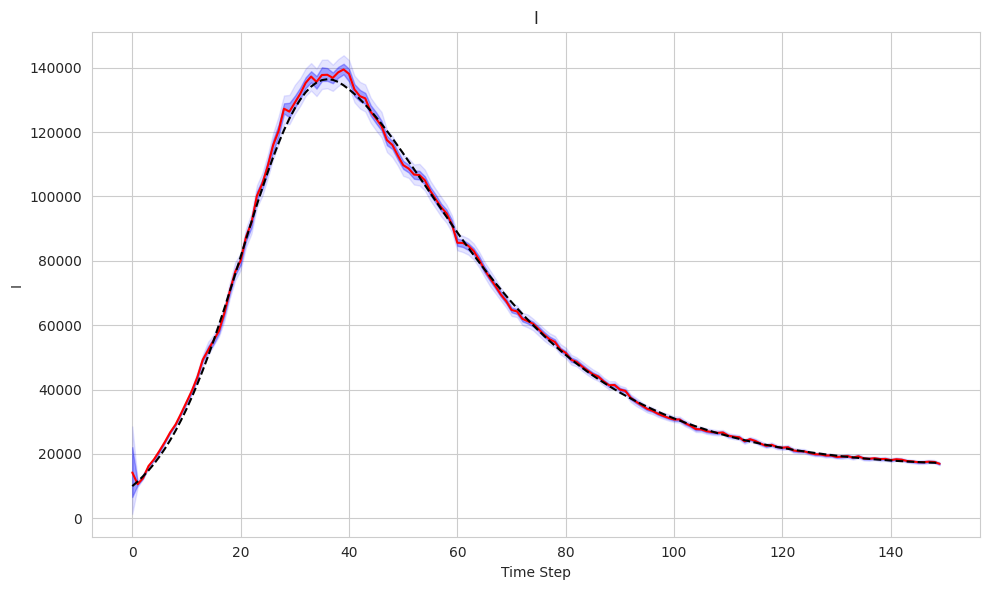

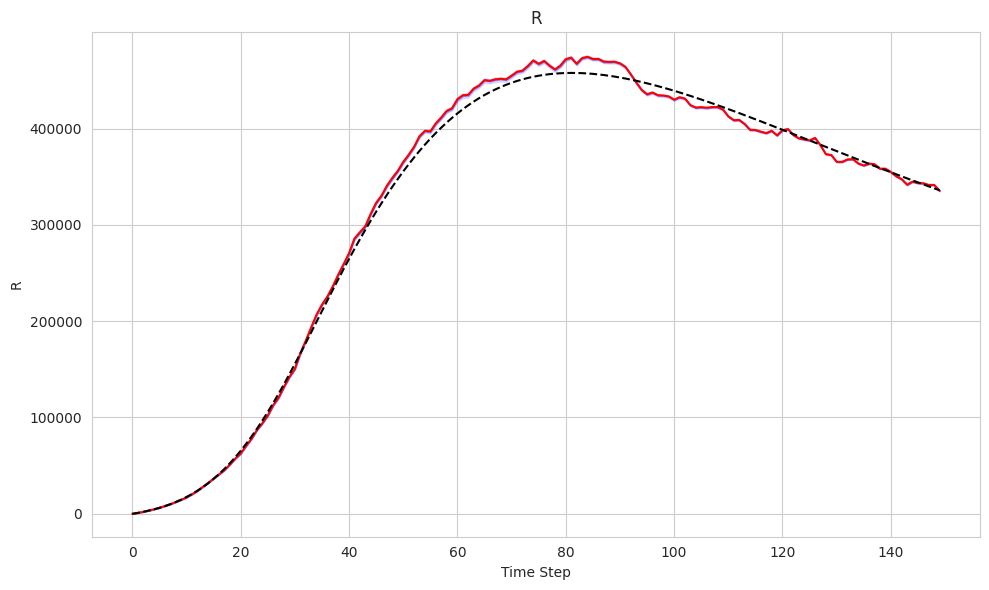

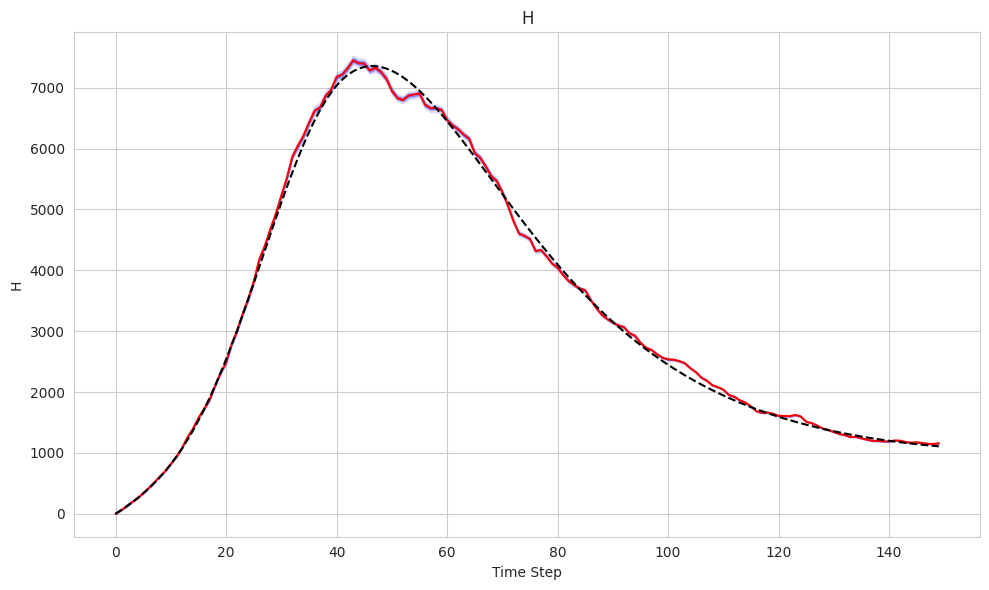

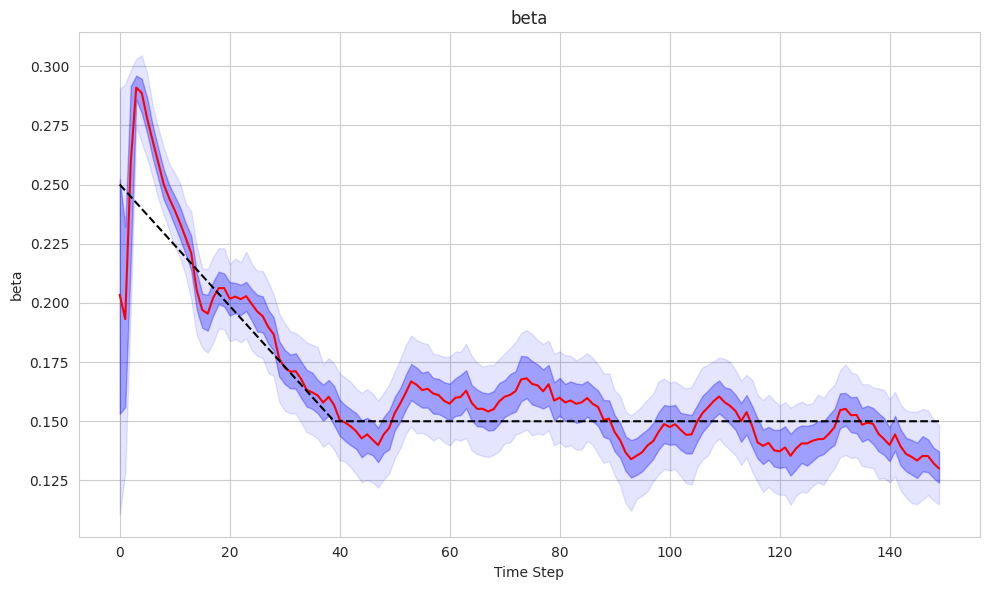

In [12]:
generate_plots(det_output, step_beta, hosp_estimates, case_reports, states)

## Increase the variance of the likelihood function

From (avg_hosp_estimate / 40) to (avg_hosp_estimate / 20)


In [2]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

Running Particle Filter: 100%|██████████| 150/150 [04:46<00:00,  1.91s/it]


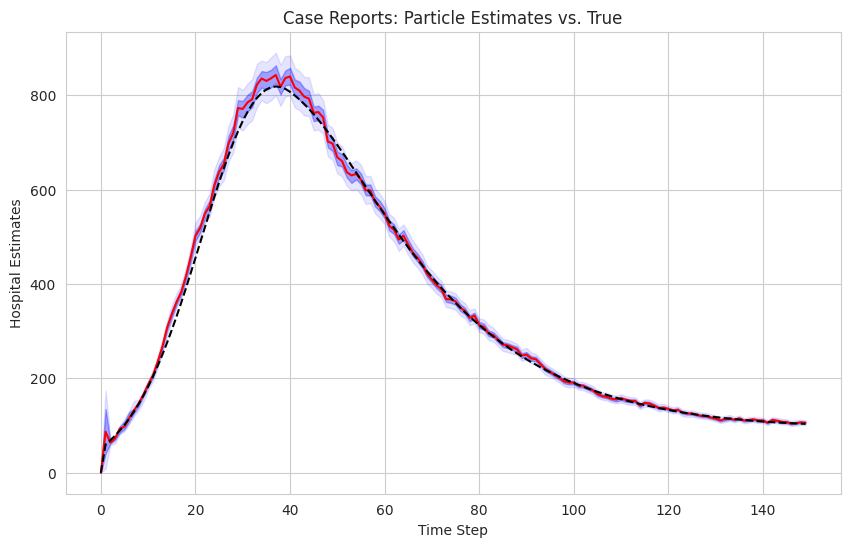

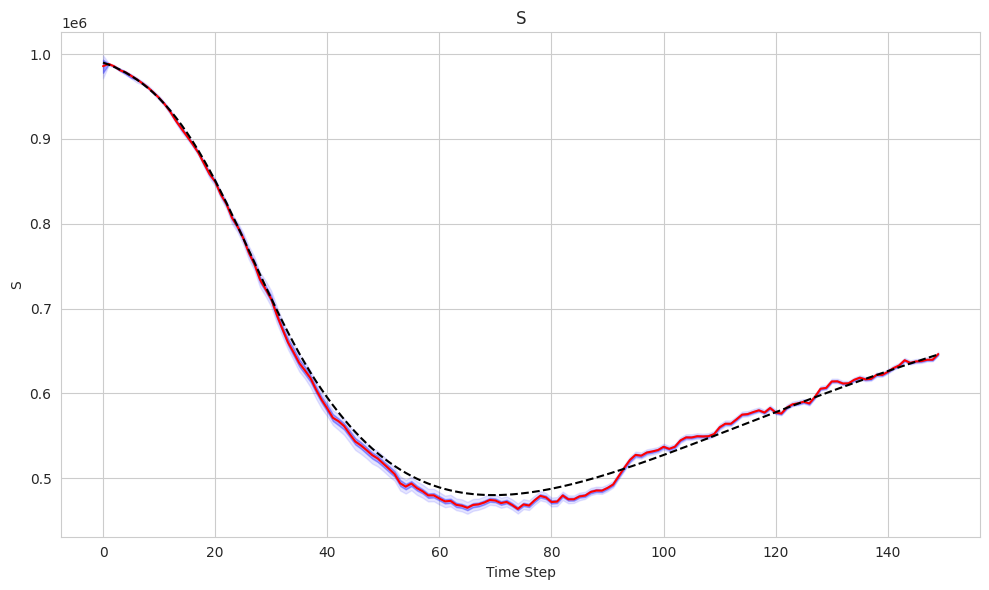

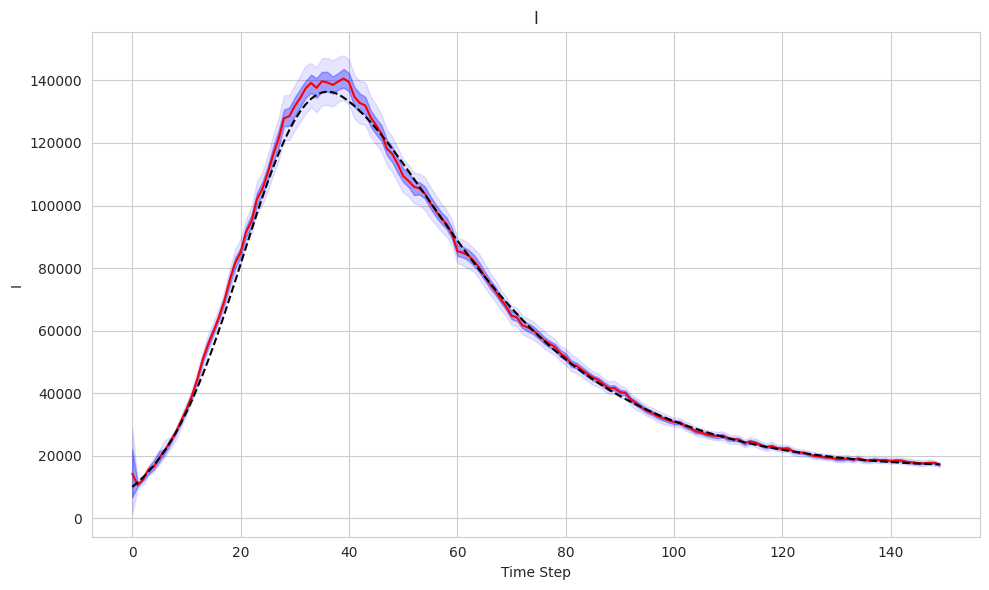

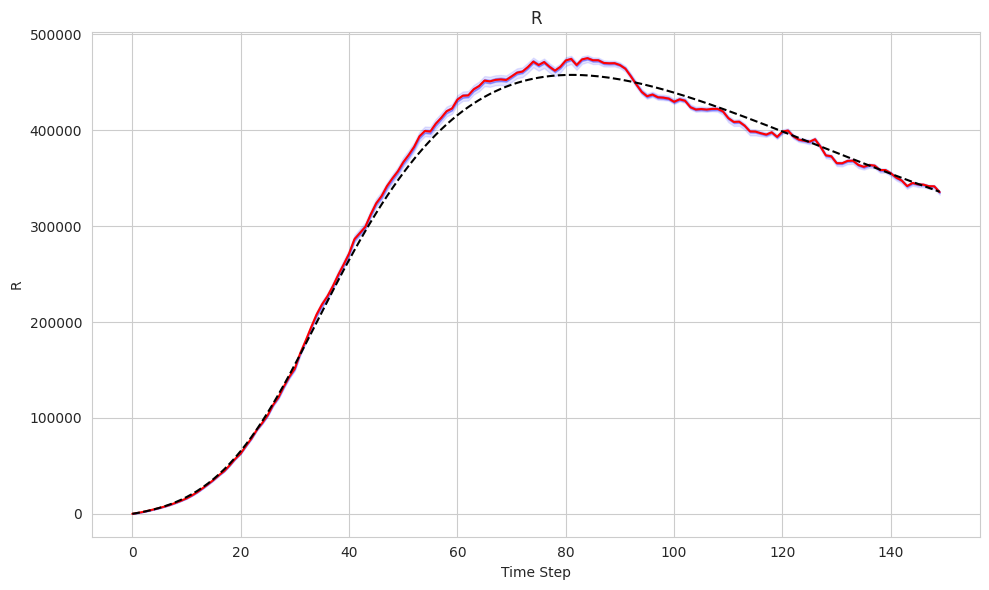

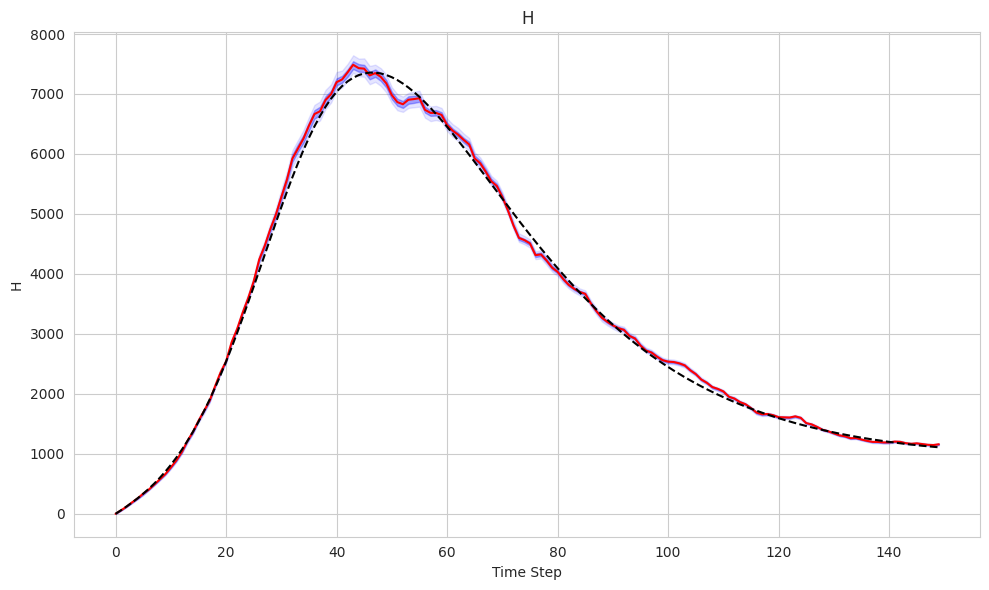

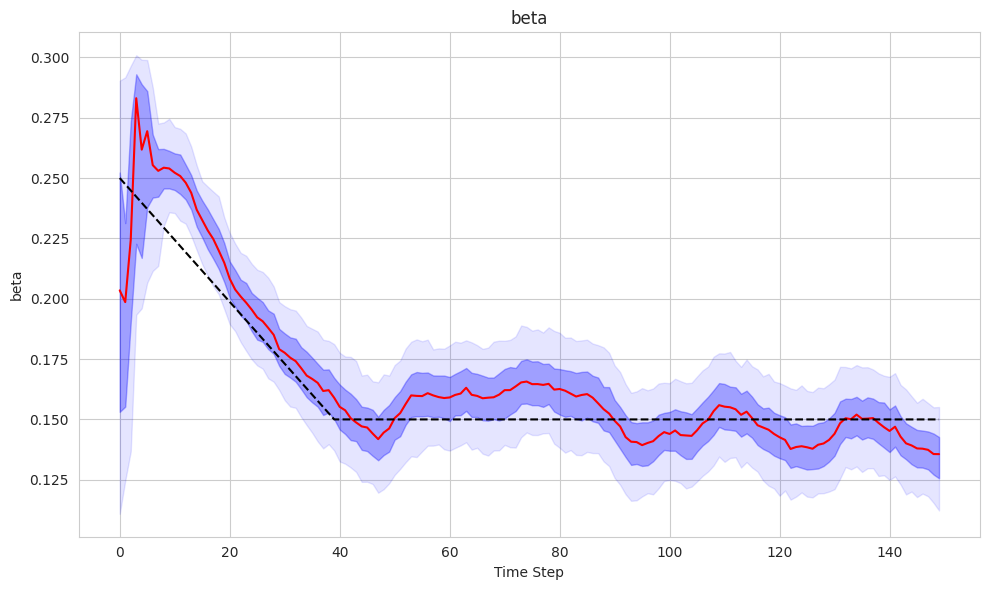

In [5]:
generate_plots(det_output, step_beta, hosp_estimates, case_reports, states)

# beta mu = 0.25, beta theta = 0.1 
beta theta is doubled from previous.

In [6]:
pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

Running Particle Filter: 100%|██████████| 150/150 [05:09<00:00,  2.06s/it]


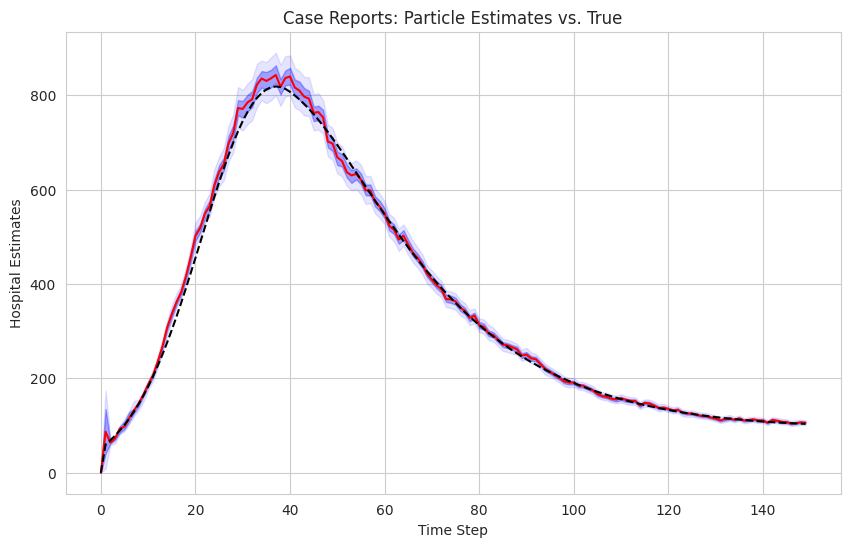

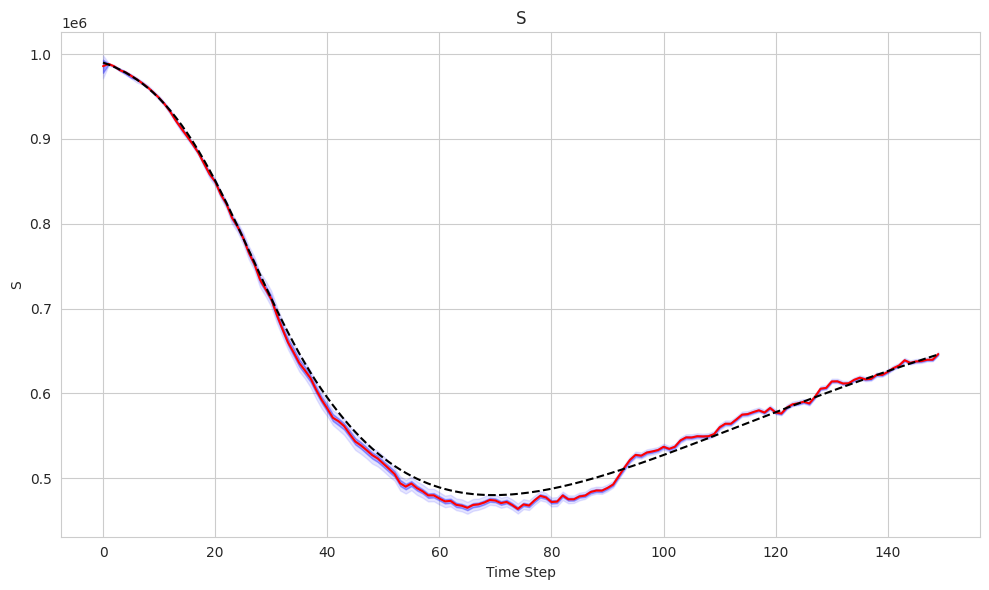

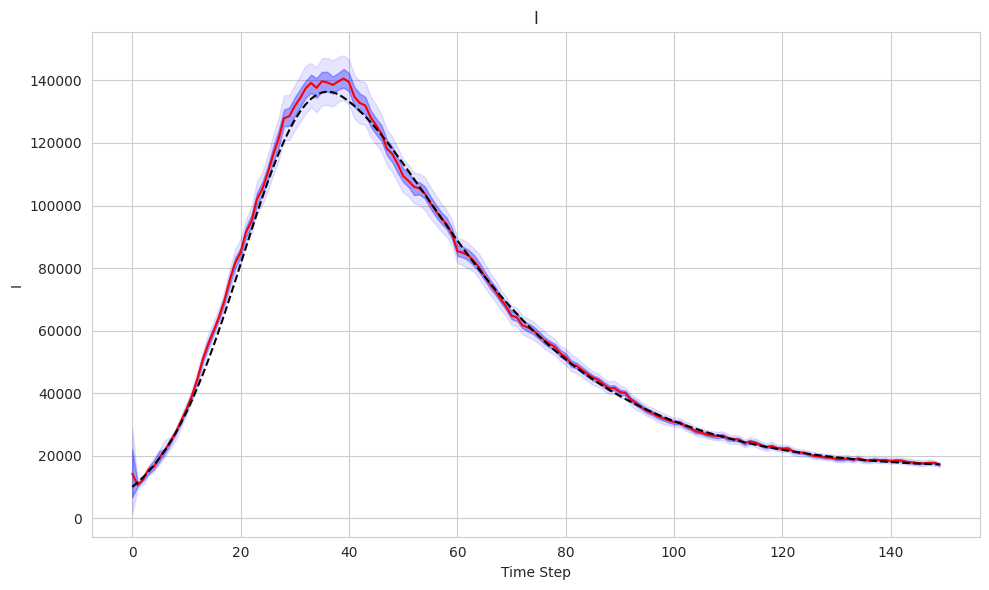

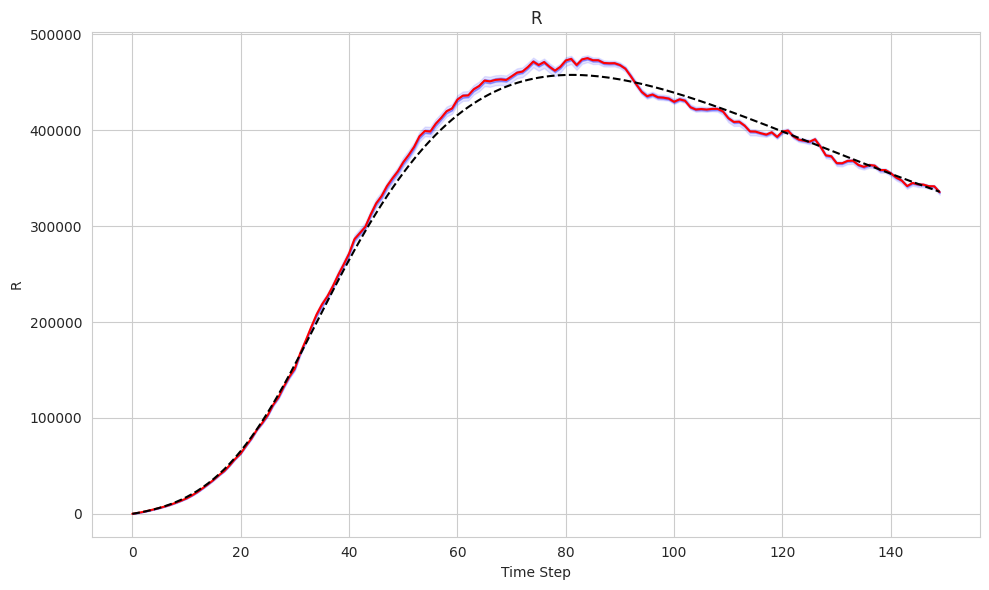

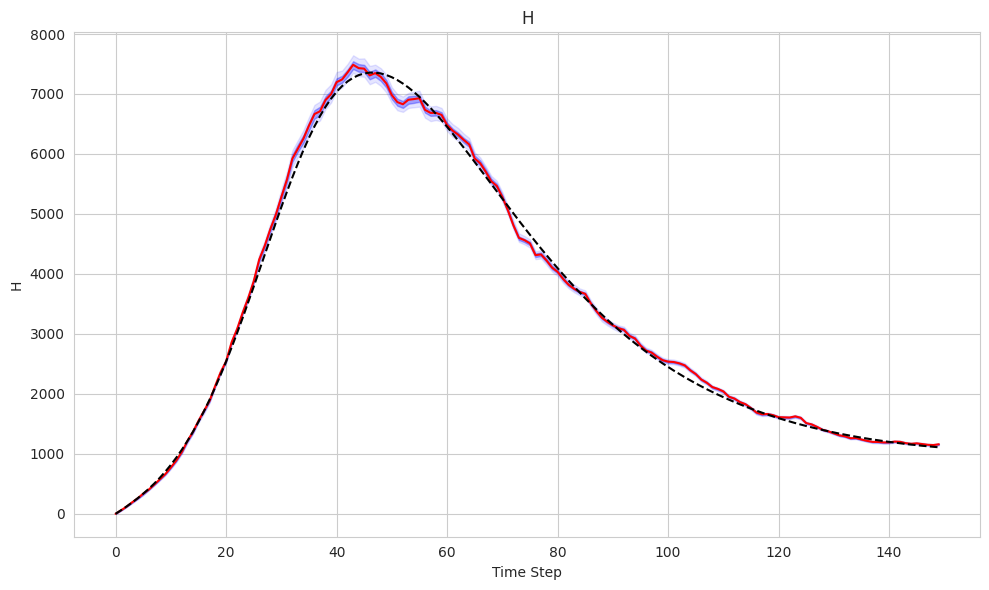

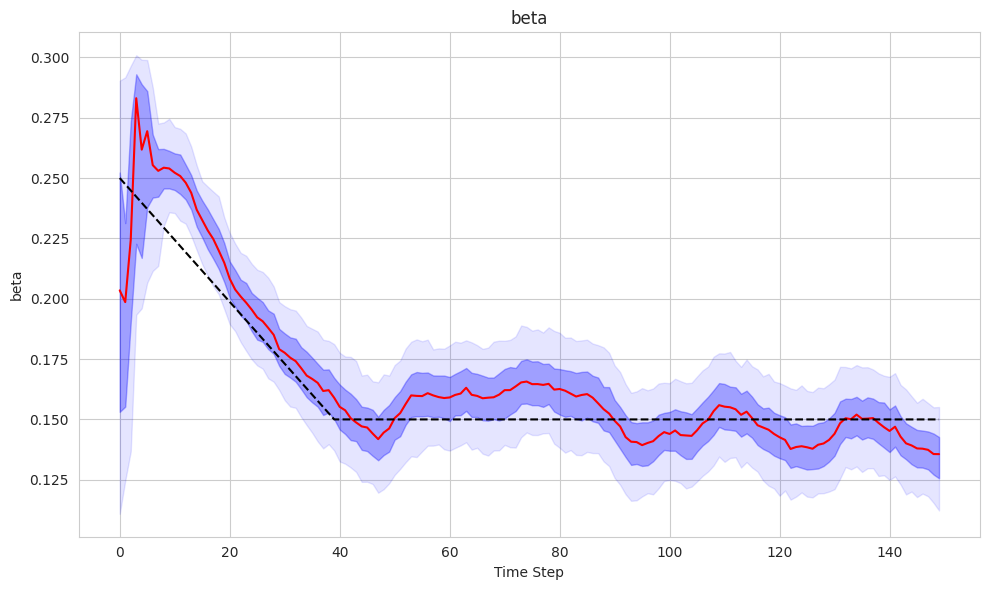

In [7]:
generate_plots(det_output, step_beta, hosp_estimates, case_reports, states)

## 5x beta theta (from 0.1 to 0.5)

In [9]:
pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

Running Particle Filter: 100%|██████████| 150/150 [05:20<00:00,  2.14s/it]


In [ ]:
generate_plots(det_output, step_beta, hosp_estimates, case_reports, states)

## Change likelihood to nbinom

In [3]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

Running Particle Filter: 100%|██████████| 150/150 [06:31<00:00,  2.61s/it]


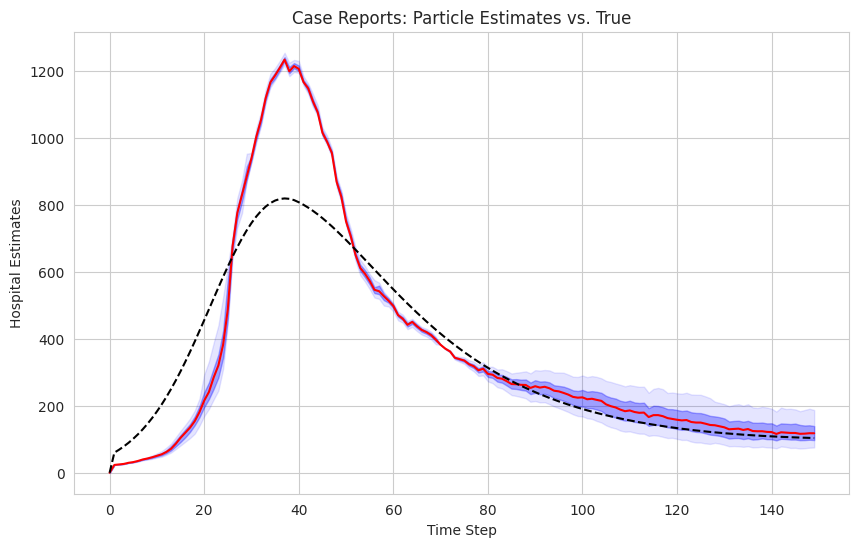

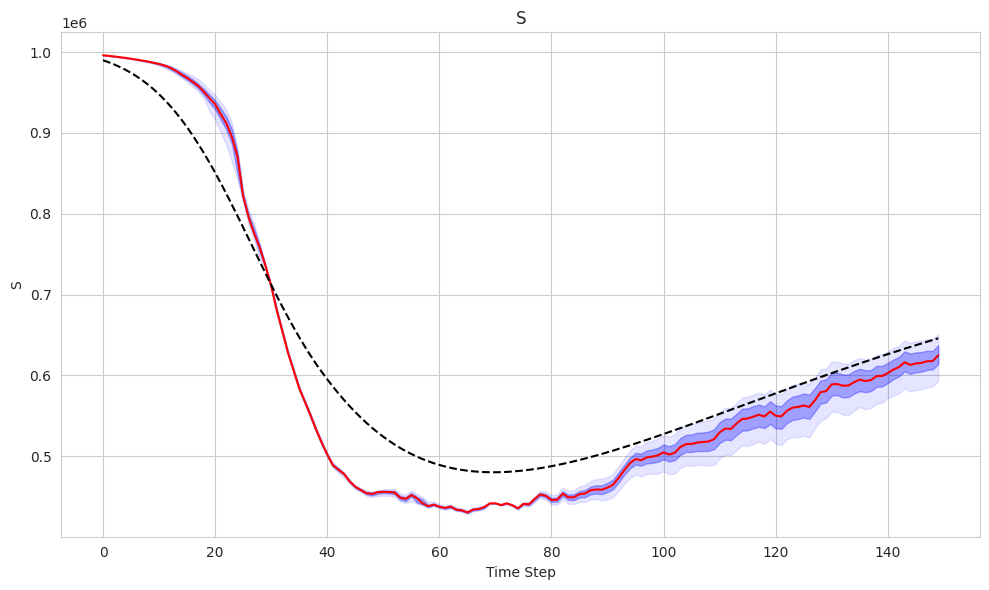

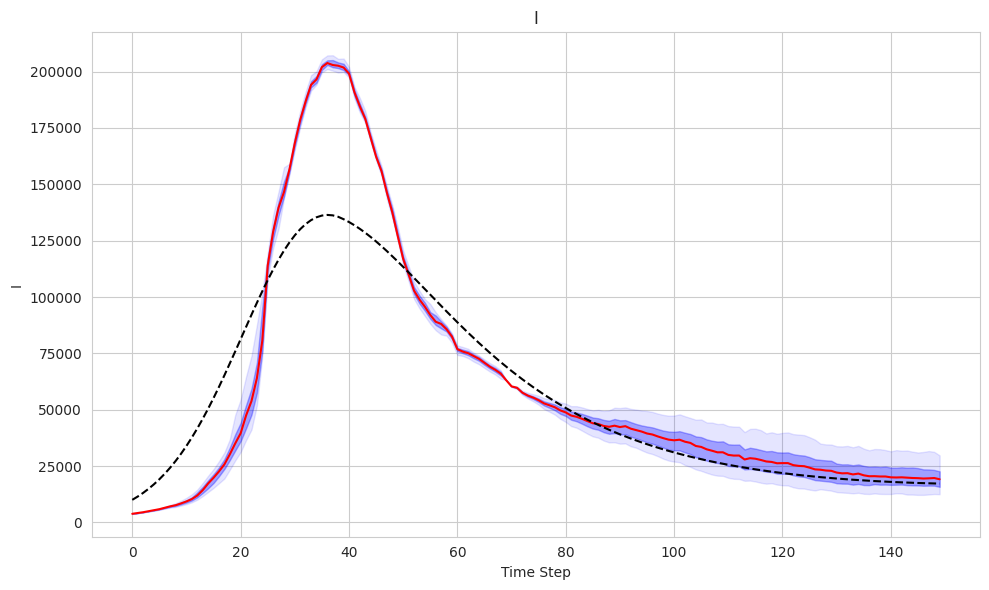

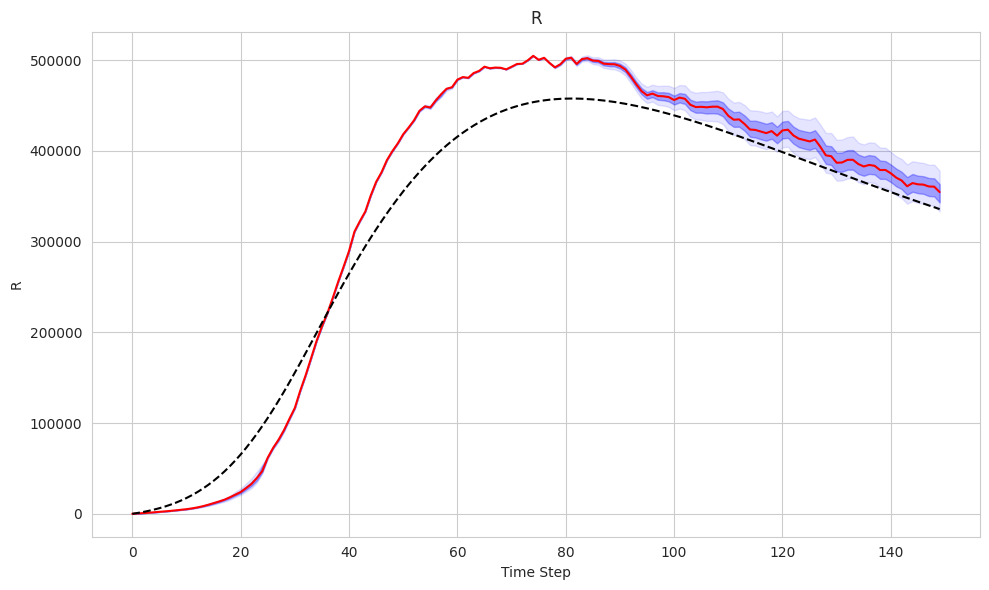

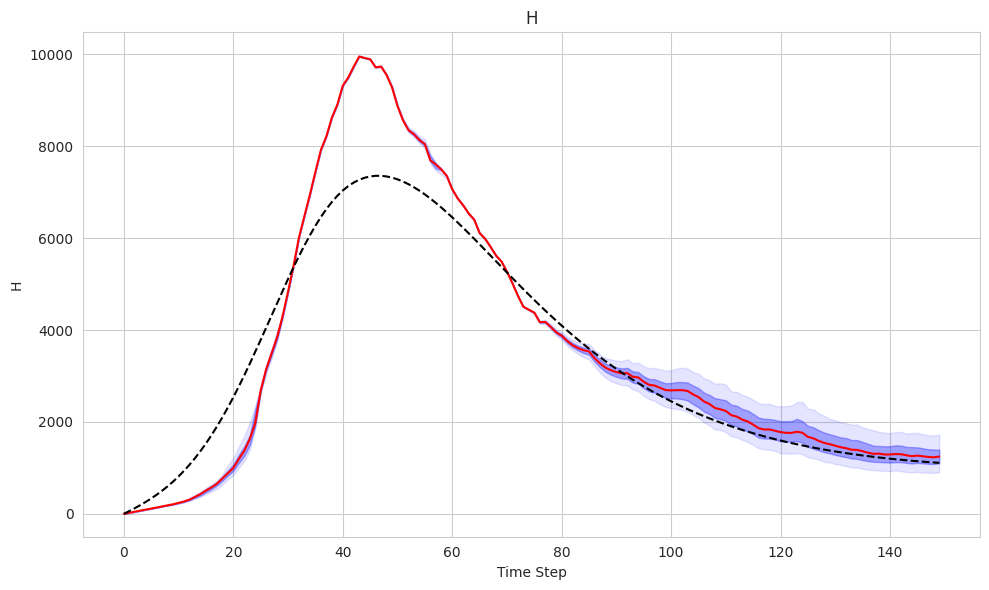

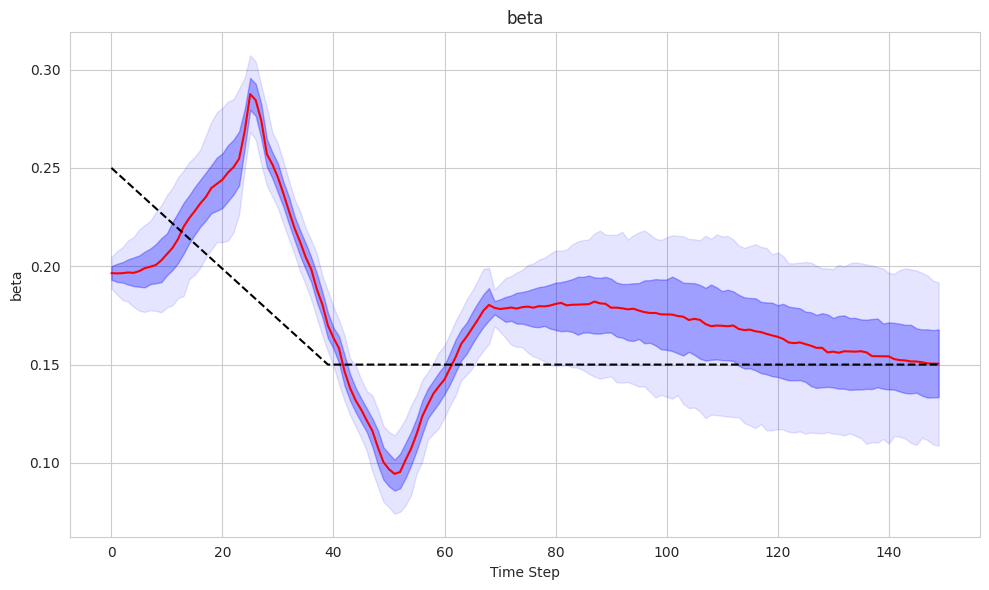

In [4]:
generate_plots(det_output, step_beta, hosp_estimates, case_reports, states)